General optimizations:
- Diro2C generation algorithm could take into account possible values for categorical features or integer features
- scikit-learn Decision tree implementation does not support categorical values, they are currently only approximated by converting them to numbers. Look into alternative implementations or encode values
- it would be better for the understanding, to see how rules evolve with increasing max depth. I used unix diff for that
- general rule for determining, how far to increase max depth parameter

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, train_surrogate_tree, plot_surrogate_tree,\
                           extract_rules, print_rules, evaluate_generated_data,\
                           evaluate, plot_tree_leafs_2d, plot_diro2c_2d, get_surrogate_tree,\
                           get_feature_importances, plot_feature_importances, set_generated_data,\
                           search_max_depth_parameter
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
with open('task_without_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
global_fidelities = {}
local_fidelities = {}
complexities = {}

## $(False, True)$

In [6]:
focus_class = '(False, True)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [7]:
explainer = WrappedDiro2C(X, comparer, focus_class)

Let's first check how long it takes to generate a data set for a single instance:

In [13]:
%%time
_ = explainer.generate_local_explanation(idx_explain=0)

CPU times: user 11min 29s, sys: 37.7 s, total: 12min 7s
Wall time: 3min 31s


In [14]:
((3*60 + 31) * len(X))/60/60

57.26305555555555

In [11]:
%%time
_ = explainer.generate_local_explanation(idx_explain=0, gn_population_size=500)

CPU times: user 1min 6s, sys: 4.77 s, total: 1min 11s
Wall time: 21 s


In [12]:
(21 * len(X))/60/60

5.699166666666667

Even with a reduced population size parameter it still would take more than 5 hours to generate data sets for all instances. I'll use a different approach, where the final data set is built from the merged generated data sets created for only the instances classified differently, but with the default population size parameter. This way, I expect the algorithm to generate instances near to the already known differences.

In [7]:
instance_indices = np.where(y_true)[0]

In [8]:
%%time
explanations = []
for i, instance_idx in enumerate(instance_indices, 1):
    print(f'{i}/{len(instance_indices)}')
    explanation = explainer.generate_local_explanation(instance_idx)
    explanations.append(explanation)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump((explainer, explanations), f, pickle.HIGHEST_PROTOCOL)

1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12
CPU times: user 2h 14min 22s, sys: 7min 21s, total: 2h 21min 44s
Wall time: 40min 33s


In [8]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explainer, explanations = pickle.load(f)

In [9]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

In [10]:
X_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['X']
                            for explanation in explanations])
y_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['y']
                            for explanation in explanations])

In [11]:
explanation = explanations[0]
set_generated_data(explanation, X_explain, y_explain)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


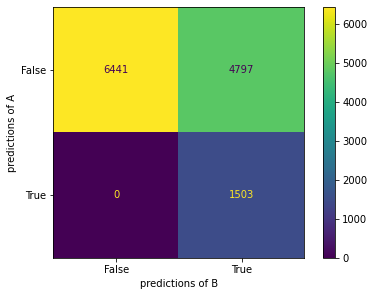

In [12]:
comparer.plot_confusion_matrix(X_explain)

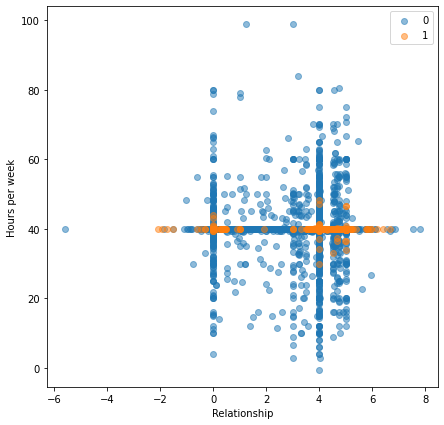

In [13]:
plot_diro2c_2d(explanation, 'Relationship', 'Hours per week')

### Find Optimal Solution

In [14]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true)

CPU times: user 22.9 s, sys: 224 ms, total: 23.1 s
Wall time: 23.5 s


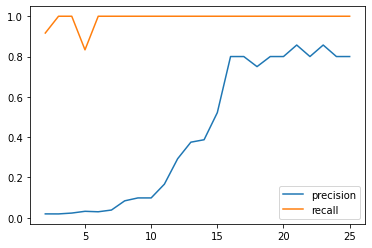

In [15]:
metrics.loc[:, ('precision', 'recall')].plot();

Parameter setting 4 is the one with the highest precision among the settings that achieve perfect recall and have a low number of rules (2). It will serve as the global explanation.

For the local explanations, we could go as far as max depth 16, which yields seven rules and has 80\% precision. But 95 constraints in total are not human-friendly. Precision increases steeply for the first time up to max depth 12, which consists of four rules and 45 constraints.

In [16]:
metrics[(metrics['recall'] > 0.99) & (metrics['rules'] <= 7)]

,precision,recall,rules,constraints
3,0.018987,1.0,2,6
4,0.023211,1.0,2,8
6,0.029630,1.0,3,16
7,0.038217,1.0,3,19
8,0.083916,1.0,3,22
9,0.098361,1.0,3,25
10,0.098361,1.0,4,38
11,0.166667,1.0,4,41
12,0.292683,1.0,4,45
13,0.375000,1.0,4,48


### Tree with depth 4

In [17]:
%%time
max_depth = 4
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 23.9 ms, sys: 4.11 ms, total: 28 ms
Wall time: 34.8 ms


In [18]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7944
           1       0.64      0.91      0.75      4797

    accuracy                           0.77     12741
   macro avg       0.78      0.80      0.77     12741
weighted avg       0.82      0.77      0.77     12741



In [19]:
evaluate(explanation, X, y_true);

              precision    recall  f1-score   support

           0       1.00      0.48      0.64       965
           1       0.02      1.00      0.05        12

    accuracy                           0.48       977
   macro avg       0.51      0.74      0.34       977
weighted avg       0.99      0.48      0.64       977



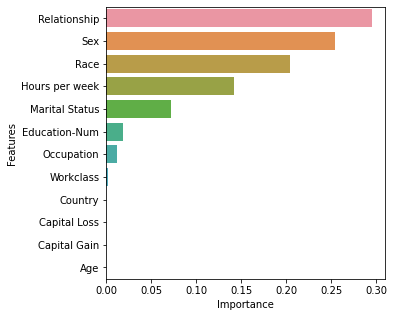

In [20]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 5))

In [21]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

4

Rule 1 explains all instances classified $(False, True)$ of the original data set, except #925, which is explained by rule 2.

In [22]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

64     1
70     1
406    1
484    1
531    1
558    1
701    1
744    1
883    1
925    2
948    1
961    1
dtype: int64

In [23]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [24]:
print_rules(rules, class_occurences)

1. Relationship <= 4.402771711349487 and Race > 3.5443339347839355 and Sex > 0.649721771478653 and `Hours per week` > 39.67813491821289 [2387, 3942]
2. `Marital Status` <= 2.47591769695282 and Relationship > 4.765960454940796 and Race > 3.481161594390869 and Sex <= 0.649721771478653 [84, 375]


#### Evaluation

##### Global Fidelity

In [25]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       1.00      0.48      0.64       965
           1       0.02      1.00      0.05        12

    accuracy                           0.48       977
   macro avg       0.51      0.74      0.34       977
weighted avg       0.99      0.48      0.64       977



##### Counterfactual Fidelity Error

In [26]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide


In [27]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
Age,NaN,1.000000,NaN
Workclass,NaN,1.000000,NaN
Education-Num,NaN,1.000000,NaN
Marital Status,0.475918,0.916667,0.000000
Occupation,NaN,1.000000,NaN
Relationship,2.012239,0.473684,0.166667
Race,2.324163,0.000000,0.000000
Sex,0.649722,0.000000,0.250000
Capital Gain,NaN,1.000000,NaN
Capital Loss,NaN,1.000000,NaN


##### Complexity

In [28]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          2
Constraints    8
dtype: int64

##### Stability

In [29]:
with open('explanation-diro2c-orig-01-global.pickle', 'wb') as f:
    pickle.dump((rules, constraints, instance_indices_per_rule), f)

### Tree with depth 12

In [30]:
%%time
max_depth = 12
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 49.7 ms, sys: 2.46 ms, total: 52.2 ms
Wall time: 57.7 ms


In [31]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7944
           1       0.93      0.96      0.95      4797

    accuracy                           0.96     12741
   macro avg       0.95      0.96      0.96     12741
weighted avg       0.96      0.96      0.96     12741



In [32]:
evaluate(explanation, X, y_true);

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       965
           1       0.12      1.00      0.22        12

    accuracy                           0.91       977
   macro avg       0.56      0.96      0.59       977
weighted avg       0.99      0.91      0.94       977



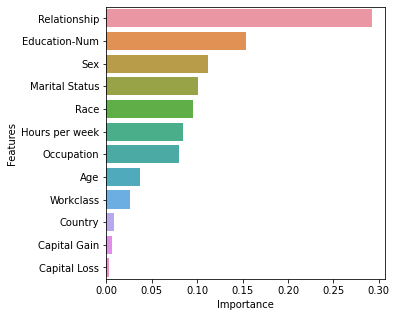

In [33]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 5))

In [34]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

162

Rule 1 explains all instances classified $(False, True)$ of the original data set, except #925, which is explained by rule 2.

In [35]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

64     1
70     2
406    1
484    1
531    3
558    3
701    1
744    1
883    2
925    4
948    1
961    1
dtype: int64

In [36]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [37]:
print_rules(rules, class_occurences)

1. Age > 44.64775276184082 and Workclass <= 5.149443626403809 and 8.688964366912842 < `Education-Num` <= 12.533215522766113 and `Marital Status` <= 2.5048539638519287 and Occupation <= 4.317143678665161 and 3.7380428314208984 < Relationship <= 4.402771711349487 and Race > 3.5443339347839355 and Sex > 0.649721771478653 and 39.67813491821289 < `Hours per week` <= 41.526845932006836 [236, 2434]
2. Age > 27.72172451019287 and Workclass <= 5.149443626403809 and `Education-Num` > 12.502001285552979 and `Marital Status` <= 2.5048539638519287 and Occupation > 4.317143678665161 and 3.7380428314208984 < Relationship <= 4.402771711349487 and Race > 3.5443339347839355 and Sex > 0.649721771478653 and 39.67813491821289 < `Hours per week` <= 41.526845932006836 [65, 671]
3. Age > 37.10478210449219 and Workclass <= 5.409208297729492 and `Education-Num` > 13.928133964538574 and `Marital Status` <= 5.873736619949341 and Occupation > 9.492910385131836 and Relationship <= 0.5058151483535767 and Race > 3.54

#### Evaluation

##### Global Fidelity

In [38]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       965
           1       0.12      1.00      0.22        12

    accuracy                           0.91       977
   macro avg       0.56      0.96      0.59       977
weighted avg       0.99      0.91      0.94       977



##### Counterfactual Fidelity Error

In [39]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide


In [40]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
Age,5.611577,0.458333,0.000000
Workclass,0.220723,0.450000,0.000000
Education-Num,1.240652,0.173913,0.000000
Marital Status,0.579354,0.000000,0.000000
Occupation,1.600959,0.478261,0.000000
Relationship,0.612859,0.000000,0.095238
Race,2.324163,0.000000,0.000000
Sex,0.649722,0.000000,0.250000
Capital Gain,2927.750977,0.923077,0.000000
Capital Loss,NaN,1.000000,NaN


##### Complexity

In [41]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules           4
Constraints    45
dtype: int64

##### Stability

In [42]:
with open('explanation-diro2c-orig-01-local.pickle', 'wb') as f:
    pickle.dump((rules, constraints, instance_indices_per_rule), f)

# Summary

In [43]:
def map_index(index):
    class_, depth = index[0], index[1]
    if depth == 4:
        level = 'global'
    elif depth == 12:
        level = 'local'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Global Fidelity

In [44]:
global_fidelity = pd.concat(global_fidelities.values(), keys=global_fidelities.keys(), names=('depth', 'class'))
global_fidelity = global_fidelity[global_fidelity.index.get_level_values(2).astype(int) == 1]
global_fidelity.index = global_fidelity.index.droplevel(2)
global_fidelity = global_fidelity.reorder_levels(['class', 'depth']).sort_index()
global_fidelity

Precision  Recall  F1 Score  Support
class         depth                                      
(False, True) 4       0.023166     1.0  0.045283       12
              12      0.123711     1.0  0.220183       12

## Local Fidelity

In [45]:
local_fidelity = pd.concat(local_fidelities.values(), keys=local_fidelities.keys(), names=('depth', 'class', 'feature'))
local_fidelity = local_fidelity.reorder_levels(['class', 'depth', 'feature']).sort_index()
local_fidelity

RMSE       BMR       BAR
class         depth feature                                        
(False, True) 4     Age                     NaN  1.000000       NaN
                    Capital Gain            NaN  1.000000       NaN
                    Capital Loss            NaN  1.000000       NaN
                    Country                 NaN  1.000000       NaN
                    Education-Num           NaN  1.000000       NaN
                    Hours per week     0.678135  0.541667  0.000000
                    Marital Status     0.475918  0.916667  0.000000
                    Occupation              NaN  1.000000       NaN
                    Race               2.324163  0.000000  0.000000
                    Relationship       2.012239  0.473684  0.166667
                    Sex                0.649722  0.000000  0.250000
                    Workclass               NaN  1.000000       NaN
              12    Age                5.611577  0.458333  0.000000
                    Capital Gain    2927.750977  0.923077  0.000000
                    Capital Loss            NaN  1.000000       NaN
                    Country            0.573923  0.909091  0.000000
                    Education-Num      1.240652  0.173913  0.000000
                    Hours per week     2.002719  0.000000  0.000000
                    Marital Status     0.579354  0.000000  0.000000
                    Occupation         1.600959  0.478261  0.000000
                    Race               2.324163  0.000000  0.000000
                    Relationship       0.612859  0.000000  0.095238
                    Sex                0.649722  0.000000  0.250000
                    Workclass          0.220723  0.450000  0.000000

## Complexity

In [46]:
complexity = pd.concat(complexities.values(), axis=1, keys=complexities.keys(), names=('depth', 'class')).T
complexity = complexity.reorder_levels(['class', 'depth']).sort_index()
complexity

Rules  Constraints
class         depth                    
(False, True) 4          2            8
              12         4           45

## Generation Time

41m

In [47]:
global_fidelity.index = global_fidelity.index.map(map_index)
global_fidelity = global_fidelity[global_fidelity.index.get_level_values('depth').notnull()]
global_fidelity.index.rename(['class', 'level'], inplace=True)

local_fidelity.index = local_fidelity.index.map(map_index)
local_fidelity = local_fidelity[local_fidelity.index.get_level_values('depth').notnull()]
local_fidelity.index.rename(['class', 'level', 'feature'], inplace=True)

complexity.index = complexity.index.map(map_index)
complexity = complexity[complexity.index.get_level_values('depth').notnull()]
complexity.index.rename(['class', 'level'], inplace=True)

with open('results.soa.pickle', 'wb') as f:
    pickle.dump((global_fidelity, local_fidelity, complexity), f)